In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


In [2]:
!pip install -q transformers
import transformers 
from transformers import GPT2Model, GPT2Tokenizer 
from transformers import TextGenerationPipeline, AutoTokenizer, AutoModelForCausalLM 
from transformers import MegatronBertConfig, MegatronBertModel, BertTokenizer 

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import copy
import json

     |████████████████████████████████| 5.5 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 52.4 MB/s 
     |████████████████████████████████| 163 kB 76.4 MB/s 


# Models

* GPT2-XL 1.5B(Decoder-only)
* Pangu $\alpha$ 2.6B: [Intro from Huawei](https://www.huaweicloud.com/product/modelarts/pangu.html) 
* erlangshen 1.3B: [Intro from IDEA](https://huggingface.co/IDEA-CCNL/Erlangshen-MegatronBert-1.3B)

# Visualization & Sparsification


In [3]:
def get_params_plot(model, model_name, sparsity=0):
  # get params dist.
  fig, ax = plt.subplots(figsize=(12,8))
  total_param = torch.cat([params.flatten() for params in model.parameters()]).detach().numpy()
  hist, bins = np.histogram(total_param, bins = np.linspace(-1,1,201)) 
  ax.plot(bins[:-1],hist) 
  plt.title("distribution of all weights(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
  plt.xlabel("Weight values")
  plt.ylabel("Log Count")
  plt.yscale('log')
  plt.show()
  plt.savefig('{}/figs/vis_all_params_{}_sparsity_{}%.png'.format(os.getcwd(), model_name, sparsity))

  if model_name == 'pangu':
    for child in model.named_children():
      if child[0] == 'transformer':
        model = child[1]
  
  if model_name == 'erlangshen':
    for child in model.named_children():
      if child[0] == 'encoder':
        model = child[1]
  
  # get params dist. in each layer
  for elem in model.named_children():
    if elem[0] == 'h' or elem[0] == 'layer': # erlangshen model uses layer as attr name ...
      fig, ax = plt.subplots(figsize=(12,8))
      for idx, child in enumerate(elem[1].named_children()):
        layer_param = torch.cat([params.flatten() for params in child[1].parameters()]).detach().numpy()
        hist, bins = np.histogram(layer_param, bins = np.linspace(-1,1,201)) 
        ax.plot(bins[:-1],hist,label="{} hidden layer".format(idx)) 
      plt.title("distribution of weights across layers(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
      plt.xlabel("Weight values")
      plt.ylabel("Log Count")
      plt.yscale('log')
      plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
      plt.show()
      plt.savefig('{}/figs/vis_layers_params_{}_sparsity_{}%.png'.format(os.getcwd(), model_name, sparsity))

In [4]:
def prune_model(model, model_name, prune_portion):
  '''
  using global pruning to prune gpt2, pangu, and erlangshen. 
  '''
  def print_sparsity(module_lst, prune_flag):

    zero_params_count = sum([torch.sum(module[0].weight == 0) for module in module_lst])
    total_params_count = sum([module[0].weight.nelement() for module in module_lst])

    print(
        "Global sparsity of model: {} in hidden layers {} pruning: {:.2f}%".format(model_name, prune_flag,
                                                    100. * float(zero_params_count)
                                                        / float(total_params_count)
                                                    )
        )
    return None
    
  if model_name == 'pangu':
    modules = model.transformer.h.modules()
  elif model_name == 'erlangshen':
    modules = model.encoder.layer.modules()
  else:
    modules = model.h.modules()

  module_lst = []
  for module in modules:
    if hasattr(module, 'weight'):
      module_lst.append((module, 'weight'))

  print_sparsity(module_lst, prune_flag = 'before')
  prune.global_unstructured(module_lst, 
                            pruning_method=prune.L1Unstructured, 
                            amount=prune_portion)
  for module, attr in module_lst: 
    prune.remove(module, attr)
  print_sparsity(module_lst, prune_flag = 'after')
  return model

In [5]:
# Method from https://discuss.pytorch.org/t/finding-model-size/130275/5
def get_model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('model size: {:.3f}MB'.format(size_all_mb))
  return size_all_mb

Start sparsifying...
Global sparsity of model: before in hidden layers GPT2-xl pruning: 0.00%
Global sparsity of model: after in hidden layers GPT2-xl pruning: 0.00%
model size: 486.700MB


KeyboardInterrupt: ignored

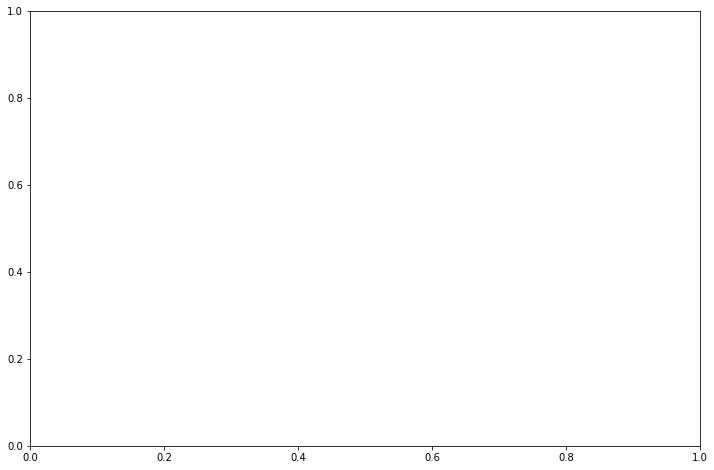

In [13]:
gpt2 = GPT2Model.from_pretrained('gpt2-xl')
pangu = AutoModelForCausalLM.from_pretrained("imone/pangu_2_6B", trust_remote_code=True)
erlangshen = MegatronBertModel.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")

model_names = ['GPT2-xl', 'pangu', 'erlangshen']
model_lst = [gpt2, pangu, erlangshen]

# gpt2 = GPT2Model.from_pretrained('gpt2')
# model_names = ['GPT2-xl']
# model_lst = [gpt2]

sparsity = [0, 0.1, 0.5, 0.9, 0.95, 0.99] 

model_size_dic = dict()

print("Start sparsifying...")
for model, model_name in zip(model_lst, model_names):
  for prune_proportion in sparsity:
    target_model = copy.deepcopy(model)
    if sparsity != 0:
      target_model = prune_model(target_model, model_name, prune_proportion)
    model_size_dic[f'{model_name}_sparsity_{prune_proportion*100}%'] = get_model_size(target_model)
    get_params_plot(target_model, model_name, prune_proportion)
    target_model.save_pretrained("{}/models/{}_sparsity_{}".format(os.getcwd(), 
                                                            model_name,
                                                            prune_proportion*100,
                                                            ))
    print("model {} with sparsity {} saved".format(model_name, prune_proportion * 100))
    
print("Sparsification completed!")


In [18]:
dir_open = open(f'{os.getcwd()}/model_size.json', "w")
json.dump(model_size_dic, dir_open, indent = 4)

# Evaluation on Benchmarks

For GPT2: GLUE(cola) and CLM(using wikitext)

For pangu, erlangshen: CLUE (tnews and cmnli)

In [3]:
!pip install -q transformers
import transformers 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM 
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

import torch
import numpy as np
import pandas as pd 

!pip install -q datasets
import datasets
from datasets import load_metric, load_dataset

import json

     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 68.6 MB/s 
     |████████████████████████████████| 7.6 MB 47.8 MB/s 
     |████████████████████████████████| 441 kB 5.2 MB/s 
     |████████████████████████████████| 95 kB 4.8 MB/s 
     |████████████████████████████████| 115 kB 76.3 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 
     |████████████████████████████████| 127 kB 78.1 MB/s 
     |████████████████████████████████| 115 kB 75.8 MB/s 


In [3]:
import os 
# change dir
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [4]:
model_names = ['GPT2-xl', 'pangu', 'erlangshen']
tokenizers_address = ['gpt2-xl', 'imone/pangu_2_6B', "IDEA-CCNL/Erlangshen-MegatronBert-1.3B"]
sparsity = [0, 0.1, 0.5, 0.9, 0.95, 0.99] 

models = dict()
tokenizers = dict()
for model_name, tokenizer_add in zip(model_names, tokenizers_address):
  tokenizers[model_name] = tokenizer_add
  models[model_name] = []
  for prune_proportion in sparsity:
    models[model_name].append(f'{os.getcwd()}/models/{model_name}_sparsity_{prune_proportion}')

## Running Benchmarks

In [ ]:
def run_benchmarks_gpt(models, sparsity, tokenizers, model_name='GPT2-xl'):
  '''
  run benchmarks
    GPT2-xl: GLUE(cola) and CLM(wikitext v2)
  '''
  # from https://ifwind.github.io/2021/08/31/BERT实战——（7）生成任务-语言模型/#调用分词器对所有的文本分词
  # for  CLM
  def group_texts(examples):
    block_size = 256
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result
  
  # CLM
  def tokenize_function_clm(examples):
    return tokenizer(examples["text"])

  # GLUE
  def tokenize_function_glue(examples):
    return tokenizer(examples["sentence"], padding="max_length", max_length=256, truncation=True)
  
  # for GLUE 
  def compute_metrics(eval_pred, metric):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

  tokenizer = AutoTokenizer.from_pretrained(tokenizers[model_name])
  tokenizer.pad_token = tokenizer.eos_token
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  for idx, model in enumerate(models[model_name]):
    for task in ['clm', 'glue']:
      if task == 'clm':
        dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')
        tokenized_datasets = dataset.map(tokenize_function_clm, batched=True, remove_columns=["text"])
        tokenized_datasets = tokenized_datasets.map(group_texts, batched=True, batch_size=1000)
        model = AutoModelForCausalLM.from_pretrained(models[model_name][idx])
      else:
        dataset = datasets.load_dataset('glue', 'cola')
        metric = load_metric("glue", "cola")
        tokenized_datasets = dataset.map(tokenize_function_glue, batched=True)
        model = AutoModelForSequenceClassification.from_pretrained(models[model_name][idx], 
                                                                   num_labels=2)
      
      model.config.pad_token_id = model.config.eos_token_id
      train_dataset = tokenized_datasets["train"].shuffle(seed=42)
      eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)
      training_args = TrainingArguments(output_dir=f"{os.getcwd()}/{model_name}_{task}_sparsity_{sparsity[idx]*100}_output", 
                                  num_train_epochs=1,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_strategy = "steps",
                                  save_steps = 10000,
                                  evaluation_strategy="epoch")
      
      if task == 'clm':
        trainer = Trainer(
                          model=model,
                          args=training_args,
                          train_dataset=train_dataset,
                          eval_dataset=eval_dataset,
                          data_collator=data_collator,
                          )
      else:
        trainer = Trainer(
                          model=model,
                          args=training_args,
                          train_dataset=train_dataset,
                          eval_dataset=eval_dataset,
                          data_collator=data_collator,
                          compute_metrics=compute_metrics,
                          )

      train_results = trainer.train()
      eval_results = trainer.evaluate()
      result = {'train': train_results.metrics,
                'eval': eval_results}
      dir_open = open(f'{os.getcwd()}/benchmark/{model_name}_{task}_sparsity_{sparsity[idx]*100}_results.json', "w")
      json.dump(result, dir_open, indent = 4)

In [ ]:
def run_benchmarks_chinese(models, sparsity, tokenizers, model_name):
  '''
  run benchmarks for:
    pangu: CLUE(tnews) and CLUE(cmnli)
    erlangshen: CLUE(tnews) and CLUE(cmnli)
  '''
  # CLM
  def tokenize_function_clm(examples):
    return tokenizer(examples["text"])

  # GLUE
  def tokenize_function_glue(examples):
    return tokenizer(examples["sentence"], padding="max_length", max_length=256, truncation=True)
  
  # for GLUE 
  def compute_metrics(eval_pred, metric):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

  tokenizer = AutoTokenizer.from_pretrained(tokenizers[model_name])
  tokenizer.pad_token = tokenizer.eos_token
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  for idx, model in enumerate(models[model_name]):
    for task in ['clm', 'glue']:
      if task == 'clm':
        dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')
        tokenized_datasets = dataset.map(tokenize_function_clm, batched=True, remove_columns=["text"])
        tokenized_datasets = tokenized_datasets.map(group_texts, batched=True, batch_size=1000)
        model = AutoModelForCausalLM.from_pretrained(models[model_name][idx])
      else:
        dataset = datasets.load_dataset('glue', 'cola')
        metric = load_metric("glue", "cola")
        tokenized_datasets = dataset.map(tokenize_function_glue, batched=True)
        model = AutoModelForSequenceClassification.from_pretrained(models[model_name][idx], 
                                                                   num_labels=2)
      
      model.config.pad_token_id = model.config.eos_token_id
      train_dataset = tokenized_datasets["train"].shuffle(seed=42)
      eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)
      training_args = TrainingArguments(output_dir=f"{os.getcwd()}/{model_name}_{task}_sparsity_{sparsity[idx]*100}_output", 
                                  num_train_epochs=1,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_strategy = "steps",
                                  save_steps = 10000,
                                  evaluation_strategy="epoch")
      
      if task == 'clm':
        trainer = Trainer(
                          model=model,
                          args=training_args,
                          train_dataset=train_dataset,
                          eval_dataset=eval_dataset,
                          data_collator=data_collator,
                          )
      else:
        trainer = Trainer(
                          model=model,
                          args=training_args,
                          train_dataset=train_dataset,
                          eval_dataset=eval_dataset,
                          data_collator=data_collator,
                          compute_metrics=compute_metrics,
                          )

      train_results = trainer.train()
      eval_results = trainer.evaluate()
      result = {'train': train_results.metrics,
                'eval': eval_results}
      dir_open = open(f'{os.getcwd()}/benchmark/{model_name}_{task}_sparsity_{sparsity[idx]*100}_results.json', "w")
      json.dump(result, dir_open, indent = 4)

In [5]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
# dataset = datasets.load_dataset('glue', 'cola')
dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [16]:
def group_texts(examples):
  block_size = 256
  concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
  total_length = len(concatenated_examples[list(examples.keys())[0]])
  total_length = (total_length // block_size) * block_size
  result = {
      k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
      for k, t in concatenated_examples.items()
  }
  result["labels"] = result["input_ids"].copy()
  return result

In [15]:
# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", max_length=256, truncation=True)

def tokenize_function(examples):
    return tokenizer(examples["text"])

# tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])



  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [17]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
)
train_dataset = lm_datasets["train"].shuffle(seed=42)
eval_dataset = lm_datasets["validation"].shuffle(seed=42)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [18]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

"awa. A large team of writers handled the script. The game's opening theme was sung by May 'n. \n It met with positive sales in Japan, and was praised by both Japanese and western critics. After release, it received downloadable content, along with an expanded edition in November of that year. It was also adapted into manga and an original video animation series. Due to low sales of Valkyria Chronicles II, Valkyria Chronicles III was not localized, but a fan translation compatible with the game's expanded edition was released in 2014. Media.Vision would return to the franchise with the development of Valkyria : Azure Revolution for the PlayStation 4. \n = = Gameplay = = \n As with previous Valkyira Chronicles games, Valkyria Chronicles III is a tactical role @-@ playing game where players take control of a military unit and take part in missions against enemy forces. Stories are told through comic book @-@ like panels with animated character portraits, with characters speaking partiall

In [19]:
training_args = TrainingArguments(output_dir=f"{os.getcwd()}/CLM_output", 
                                  num_train_epochs=1,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_strategy = "steps",
                                  save_steps = 10000,
                                  evaluation_strategy="epoch")
# metric = load_metric("glue", "cola")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [20]:
# model = AutoModelForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model = AutoModelForCausalLM.from_pretrained('gpt2')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/75e09b43581151bd1d9ef6700faa605df408979f/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_vers

In [12]:
model.config.pad_token_id = model.config.eos_token_id

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
)

train_results = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9327
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 292
  Number of trainable parameters = 124439808


Epoch,Training Loss,Validation Loss
1,No log,3.277631


***** Running Evaluation *****
  Num examples = 964
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




In [23]:
train_results.metrics

{'train_runtime': 152.936,
 'train_samples_per_second': 60.986,
 'train_steps_per_second': 1.909,
 'total_flos': 1218535391232000.0,
 'train_loss': 3.4488316366117293,
 'epoch': 1.0}

In [24]:
eval_results = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 964
  Batch size = 64


In [25]:
eval_results

{'eval_loss': 3.2776312828063965,
 'eval_runtime': 4.72,
 'eval_samples_per_second': 204.238,
 'eval_steps_per_second': 3.39,
 'epoch': 1.0}

In [44]:
result = {'train': train_results.metrics,
          'eval': eval_results}
dir_open = open(f'{os.getcwd()}/GLUE.json', "w")
json.dump(result, dir_open, indent = 4)

In [18]:
!nvidia-smi

Mon Nov 14 03:51:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    48W / 400W |  40364MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
!fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia0:        root       1092 F...m python3
/dev/nvidiactl:      root       1092 F...m python3
/dev/nvidia-uvm:     root       1092 F...m python3


# for Chinese testing

In [12]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 


In [25]:
tokenizer = AutoTokenizer.from_pretrained('imone/pangu_2_6B', trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


In [5]:
# dataset = datasets.load_dataset('clue', 'cmnli')
dataset = datasets.load_dataset('clue', 'tnews')

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/53360 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset clue downloaded and prepared to /root/.cache/huggingface/datasets/clue/tnews/1.0.0/e508b66266ba417d60e89ed8b167699cb4b56d3a2ead29b5667907d08069dbfc. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
len(set(dataset['train']['label']))

15

In [ ]:
dataset['train']['sentence']

In [30]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_additional_special_tokens',
 '_auto_class',
 '_batch_encode_plus',
 '_batch_prepare_for_model',
 '_bos_token',
 '_call_one',
 '_cls_token',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_create_repo',
 '_create_trie',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_eventually_correct_t5_max_length',
 '_from_pretrained',
 '_get_files_timestamps',
 '_get_padding_truncation_strategies',
 '_in_target_context_manager

In [31]:
def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)



  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.088 seconds.
DEBUG:jieba:Loading model cost 1.088 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


  0%|          | 0/54 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [32]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)

In [35]:
tokenizer.decode(tokenized_datasets["train"][1]["input_ids"])

'商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告'

In [39]:
training_args = TrainingArguments(output_dir=f"{os.getcwd()}/CLM_output", 
                                  num_train_epochs=1,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_strategy = "steps",
                                  save_steps = 10000,
                                  evaluation_strategy="epoch")

metric = load_metric('matthews_correlation')

In [40]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [42]:
model = AutoModelForSequenceClassification.from_pretrained('imone/pangu_2_6B', trust_remote_code=True, num_labels=15)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


ValueError: ignored

In [ ]:
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
)

train_results = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9327
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 292
  Number of trainable parameters = 124439808


Epoch,Training Loss,Validation Loss
1,No log,3.277631


***** Running Evaluation *****
  Num examples = 964
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
train_results.metrics

{'train_runtime': 152.936,
 'train_samples_per_second': 60.986,
 'train_steps_per_second': 1.909,
 'total_flos': 1218535391232000.0,
 'train_loss': 3.4488316366117293,
 'epoch': 1.0}

In [ ]:
eval_results = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 964
  Batch size = 64


In [ ]:
eval_results

{'eval_loss': 3.2776312828063965,
 'eval_runtime': 4.72,
 'eval_samples_per_second': 204.238,
 'eval_steps_per_second': 3.39,
 'epoch': 1.0}

In [ ]:
result = {'train': train_results.metrics,
          'eval': eval_results}
dir_open = open(f'{os.getcwd()}/GLUE.json', "w")
json.dump(result, dir_open, indent = 4)